In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from skimage.io import imread, imshow
import joblib
from IPython.display import HTML
from ipywidgets import interact

from joblib import Parallel, delayed
from joblib import parallel_backend

from morphomatics.manifold import Kendall
from morphomatics.manifold import Bezierfold
from morphomatics.stats import RiemannianRegression

In [2]:
contours = joblib.load("contours_registered.joblib")

In [3]:
contours = list(contours.values())

In [4]:
# read in shapes (encoded as n-by-2 array)
surfs = [np.array(c) for c in contours] # <- surf[i][j] holds j-th frame of i-th subject

In [5]:
sample_idx = 0

@interact
def plot(i=(0,len(surfs[sample_idx]),1)):
    plt.plot(*surfs[sample_idx][i].T)

interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact'…

In [6]:
# setup shape space and Bézierfold
M = Kendall(surfs[0][0].shape)

In [7]:
degrees = np.array([3, 3])
B = Bezierfold(M, degrees=degrees)
B.initFunctionalBasedStructure()

In [8]:
# map to shape space
surfs = [np.array([M.to_coords(s) for s in surfs_i]) for surfs_i in surfs]
# set corresponding times
times = [np.linspace(0., 2, len(surfs_i)+1)[:-1] for surfs_i in surfs] # <- does this make sense?

In [9]:
def reg(Y, t):
    return RiemannianRegression(M, Y, t, degrees, iscycle=True, maxiter=1000, minstepsize=1e-15).trend

# compute subject-wise trends
# with parallel_backend('multiprocessing'):
#     subjecttrends = Parallel(n_jobs=-1, prefer='threads', require='sharedmem', verbose=10)(delayed(reg)(*a) for a in zip(surfs, times))

subjecttrends = [reg(*a) for a in zip(surfs, times)]

 iter		   cost val	    grad. norm


/home/jovyan/.local/lib/python3.9/site-packages/morphomatics/manifold/Kendall.py:117: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, *_ = np.linalg.lstsq(S, rhs.reshape(-1))


    1	+3.0378015099097145e-02	3.88641435e+02
    2	+2.9686144971752960e-02	4.98521773e+02
Terminated - min stepsize reached after 2 iterations, 2.81 seconds.

 iter		   cost val	    grad. norm
    1	+6.0362795772514452e-02	6.38448968e+02
    2	+4.8974453731162874e-02	7.47289955e+02
Terminated - min stepsize reached after 2 iterations, 2.57 seconds.

 iter		   cost val	    grad. norm
    1	+7.6721742632469170e-02	5.16599076e+02
Terminated - min stepsize reached after 1 iterations, 1.90 seconds.

 iter		   cost val	    grad. norm
    1	+8.9049302121943039e-03	2.06309075e+02
    2	+8.7351424722726858e-03	2.21141889e+02
Terminated - min stepsize reached after 2 iterations, 2.58 seconds.

 iter		   cost val	    grad. norm
    1	+2.6655394691817408e-02	4.66642020e+02
    2	+2.4827317052379724e-02	4.11252410e+02
Terminated - min stepsize reached after 2 iterations, 2.66 seconds.

 iter		   cost val	    grad. norm
    1	+2.5366819728468545e-02	3.02019963e+02
    2	+2.4211534773061674e-02	3.421

In [10]:
sample_idx = 11

@interact
def plot(i=(0, len(surfs[sample_idx]) - 1, 1)):
    t = times[sample_idx][i]
    pts = subjecttrends[sample_idx].eval(t)
    plt.plot(*surfs[sample_idx][i].T)
    plt.plot(*pts.T)
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.08, 0.08)
    return plt.gca()

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

In [11]:
sample_idx = 11
for i, t in enumerate(times[sample_idx]):
    plt.figure()
    pts = subjecttrends[sample_idx].eval(t)
    
    plt.plot(*surfs[sample_idx][i].T, label="shape")
    plt.plot(*pts.T, label="regression")
    
    plt.xlim(-0.1, 0.1)
    plt.ylim(-0.08, 0.08)
    plt.axis("off")

    plt.title(f"t = {t:.1f}")
    if i == 0:
        plt.legend()

    plt.savefig(f"regression/t-{t:.2f}.png")
    plt.close()

In [12]:
n_knees = 1

# compute mean trajectory and geodesics to the data curves
mean, F = B.metric.mean(subjecttrends, n=n_knees, delta=1e-5, min_stepsize=1e-5, nsteps=20, eps=1e-5, n_stepsGeo=5,
                 verbosity=2)

|grad|=0.09421657484599161
|grad|=0.0007519107294916216
|grad|=9.796883261471003e-06
|grad|=1.4328506111847763e-07
|grad|=2.1266485832532383e-09
|grad|=3.162323812102137e-11
|grad|=4.703573355824478e-13
|grad|=0.10021337540781534
|grad|=0.0008218084035570069
|grad|=1.0346782047252061e-05
|grad|=1.4123958870358427e-07
|grad|=1.9461587847865796e-09
|grad|=2.6847514914700224e-11
|grad|=3.704225457740349e-13
|grad|=0.10760531334983389
|grad|=0.0006917094558215981
|grad|=7.851793628277328e-06
|grad|=1.0448721255169957e-07
|grad|=1.4205676476458248e-09
|grad|=1.937041455466252e-11
|grad|=2.642364870672015e-13
|grad|=0.11820255425992987
|grad|=0.0007005194941458018
|grad|=7.6359402866076e-06
|grad|=9.940426727063103e-08
|grad|=1.3251994765298591e-09
|grad|=1.7725987028484743e-11
|grad|=2.3720908358273534e-13
|grad|=0.11820255425992987
|grad|=0.0007005194941458018
|grad|=7.6359402866076e-06
|grad|=9.940426727063103e-08
|grad|=1.3251994765298591e-09
|grad|=1.7725987028484743e-11
|grad|=2.372090

/home/jovyan/.local/lib/python3.9/site-packages/morphomatics/manifold/Kendall.py:117: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, *_ = np.linalg.lstsq(S, rhs.reshape(-1))


    1	+4.3860463593260978e-05	6.07947881e-01
    2	+3.6072794210188693e-05	3.56906523e-01
    3	+3.5670733489241210e-05	3.52461567e-01
    4	+3.5650577820622552e-05	3.52235430e-01
    5	+3.5649569020049514e-05	3.52224102e-01
    6	+3.5649518532358927e-05	3.52223536e-01
    7	+3.5649516005931584e-05	3.52223507e-01
Terminated - min stepsize reached after 7 iterations, 0.76 seconds.

Step 1: Updating discrete paths...
...took 7.57 seconds to update the legs.
Evaluating energy...
Stopped because the energy increased.
Computing the mean took 20.29 seconds.


In [13]:
@interact
def plot(t=(0, 2, 0.1)):
    pts = mean.eval(t)
    plt.plot(*pts.T)
    
    pts = subjecttrends[1].eval(t)
    plt.plot(*pts.T)

interactive(children=(FloatSlider(value=1.0, description='t', max=2.0), Output()), _dom_classes=('widget-inter…

In [14]:
t = 1.0

plt.figure()
pts = mean.eval(t)
plt.plot(*pts.T)
plt.axis("off")
plt.title(f"Mean Shape at t = {t:.1f}")
plt.savefig("mean_spider/mean.png")
plt.close()

for i, trend in enumerate(subjecttrends):
    plt.figure()
    pts = trend.eval(t)
    plt.plot(*pts.T)
    plt.title(f"Regression Patient {i + 1}")
    plt.axis("off")
    plt.savefig(f"mean_spider/{i}.png")
    plt.close()

Disc-Geo-Step 1 Energy: 0.05147000289704979 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.05147000289704979 Enew - Eold: 0.0
 iter		   cost val	    grad. norm


/home/jovyan/.local/lib/python3.9/site-packages/morphomatics/manifold/Kendall.py:117: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, *_ = np.linalg.lstsq(S, rhs.reshape(-1))


    1	+5.0111765127377229e-02	1.63838635e+01
    2	+3.5005542033934932e-02	8.63730151e+00
    3	+3.4534444472344307e-02	7.25252654e+00
    4	+3.4527329288666440e-02	7.20408078e+00
    5	+3.4527227602778508e-02	7.20334642e+00
    6	+3.4527226150813148e-02	7.20333592e+00
    7	+3.4527226130081516e-02	7.20333577e+00
Terminated - min stepsize reached after 7 iterations, 0.82 seconds.

Stopped computing discrete geodesic because the energy increased in step 1.
 iter		   cost val	    grad. norm
    1	+2.2583811933074970e-02	9.28855149e+00
    2	+1.8249303283010665e-02	3.98244525e+00
Terminated - min stepsize reached after 2 iterations, 0.72 seconds.

 iter		   cost val	    grad. norm
    1	+3.0298943463794234e-02	1.40711237e+01
    2	+2.0699175713950066e-02	9.49936834e+00
    3	+2.0157962967028206e-02	8.71889072e+00
    4	+2.0127873121455281e-02	8.67125094e+00
    5	+2.0126202125930619e-02	8.66858893e+00
    6	+2.0126109335681572e-02	8.66844106e+00
    7	+2.0126104183063459e-02	8.66843285e+0

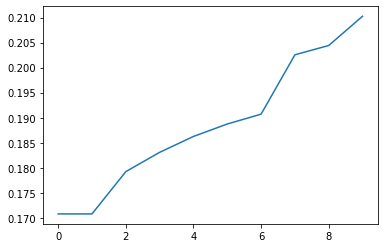

In [15]:
dists = []
for n in range(0, 10):
    d = B.metric.dist(subjecttrends[0], subjecttrends[1], n=n)
    dists.append(d)
    
plt.plot(dists)

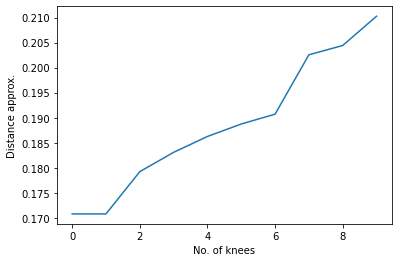

In [16]:
plt.plot(dists)
plt.xlabel("No. of knees")
plt.ylabel("Distance approx.")
plt.savefig("misc_plots/n_knees.png")

In [17]:
F_controlPoints = []
for ff in F:
    s = []
    for f in ff:
        s.append(f.control_points)
    F_controlPoints.append(s)

In [18]:
G, bet_mean, F_gram = B.metric.gram(subjecttrends, mean, F, n=n_knees)

Computing Gram matrix...
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 7.549516567451066e-15 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.023437441110902523 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.05147000289704979 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.0685469075101664 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.13410025164748146 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.014972521565408514 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.03762126487250245 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.16668050057725478 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.40978882726508237 Enew - Eold: 0.0
Disc-Geo-Step 1 Energy: 0.07690986928779689 Enew - Eold: 

In [19]:
lam, evs = np.linalg.eigh(G)

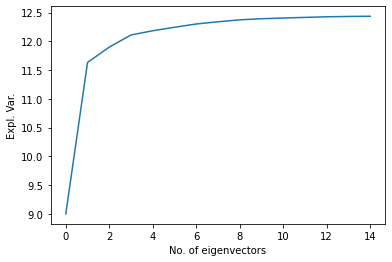

In [20]:
plt.plot(np.cumsum(lam[::-1]))
plt.xlabel("No. of eigenvectors")
plt.ylabel("Expl. Var.")
plt.savefig("misc_plots/pca.png")

In [21]:
import pickle

In [23]:
results = {
    "M": M,
    "Y": surfs,
    "param": times,
    "Bf": B,
    "S": subjecttrends,
    "B_mean": mean,
    "gram": G,
    "gram_eigvals": lam,
    "gram_eigvecs": evs,
    "n_knees": n_knees,
}

with open("results.pickle", "wb") as f:
    pickle.dump(results, f)